In [2]:
from data.mymongo import get_db
from data.scrapeReddit import get_all
import sys
import os
from pymongo import MongoClient
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 1
sys.path.append('../src')

%aimport data.scrapeReddit
%aimport data.mymongo

db = get_db()

ModuleNotFoundError: No module named 'data'

In [88]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Fetch Data

In [26]:
comments = db.comments.find({'subreddit': 'democrats'})
comms = pd.DataFrame.from_dict(comments)

In [3]:
submissions = db.submissions.find({'subreddit': 'democrats'})
subs = pd.DataFrame.from_dict(submissions)

# Clean Data

In [23]:
subs['post_date'] = subs.created_utc.map(lambda x: datetime.datetime.utcfromtimestamp(x))

In [83]:
comms['post_date'] = comms.created_utc.map(lambda x: datetime.datetime.utcfromtimestamp(x))

In [166]:
comms = comms[comms.body != '[removed]']

# Distributions

## Submissions

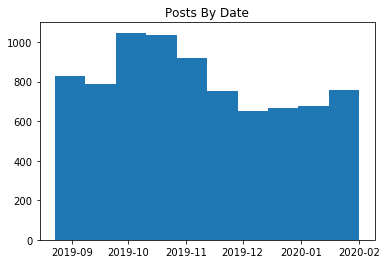

In [32]:
plt.hist(subs.post_date)
plt.title('Posts By Date');

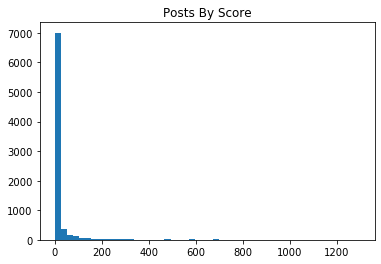

In [43]:
plt.hist(subs.score, bins=50)
plt.title('Posts By Score');

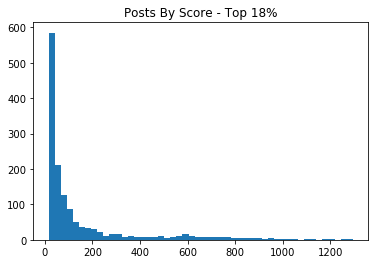

In [45]:
plt.hist(subs[subs.score > 15].score, bins=50)
plt.title('Posts By Score - Top 18%');

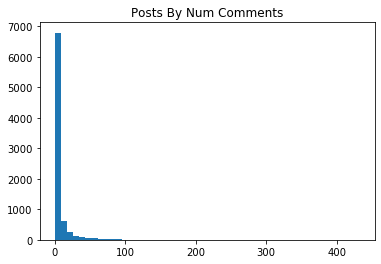

In [47]:
plt.hist(subs.num_comments, bins=50)
plt.title('Posts By Num Comments');

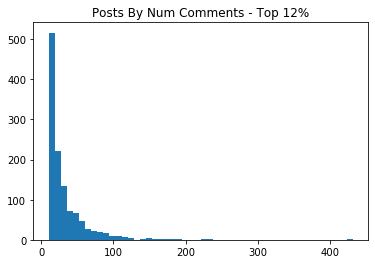

In [54]:
plt.hist(subs[subs.num_comments >= 10].num_comments, bins=50)
plt.title('Posts By Num Comments - Top 12%');

In [159]:
subs[subs.num_comments >= 10].shape[0]

1187

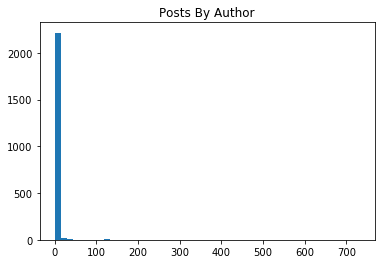

In [72]:
plt.hist(subs.groupby('author')._id.agg('count').values, bins=50)
plt.title('Posts By Author');

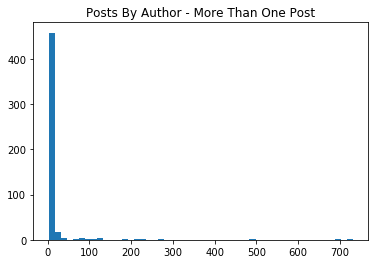

In [77]:
author_count = subs.groupby('author')._id.agg('count').reset_index()
plt.hist(author_count[author_count._id > 1]._id, bins=50)
plt.title('Posts By Author - More Than One Post');

In [82]:
# percent of posts with an award
subs[subs.total_awards_received > 0].shape[0] / subs.shape[0] * 100

0.012322858903265557

## Comments

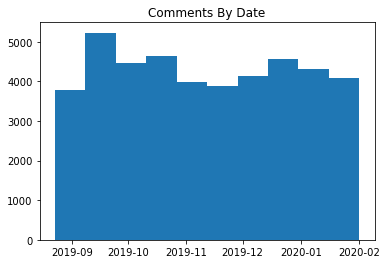

In [167]:
plt.hist(comms.post_date)
plt.title('Comments By Date');

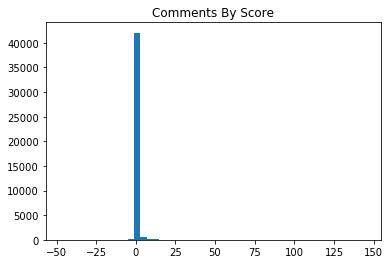

In [168]:
plt.hist(comms.score, bins=50)
plt.title('Comments By Score');

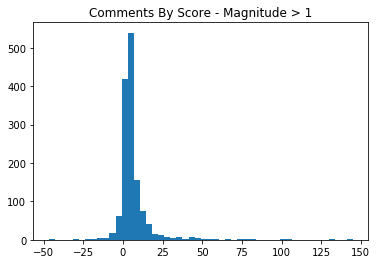

In [169]:
plt.hist(comms[np.abs(comms.score) > 1].score, bins=50)
plt.title('Comments By Score - Magnitude > 1');

In [170]:
# Percent of comments with some reaction
comms[np.abs(comms.score) > 1].shape[0] / comms.shape[0]

0.03260617312601532

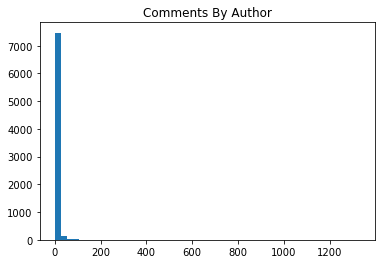

In [171]:
plt.hist(comms.groupby('author')._id.agg('count').values, bins=50)
plt.title('Comments By Author');

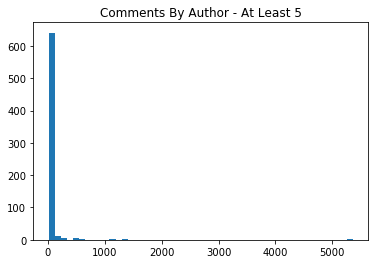

In [97]:
author_count = comms.groupby('author')._id.agg('count').reset_index()
plt.hist(author_count[author_count._id > 10]._id, bins=50)
plt.title('Comments By Author - At Least 5');

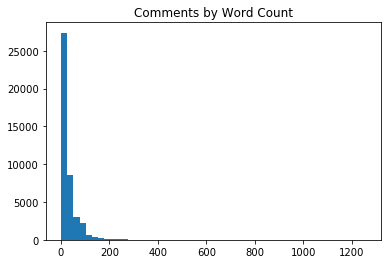

In [220]:
plt.hist(comms.body.map(lambda x: len(x.split(' '))), bins=50)
plt.title('Comments by Word Count');

**TakeAways**

- Most posts have very few comments. If I want my documents to be a reasonable length, probably need to choose a minimum number of comments
- There are some MAJOR outliers in term of commenting. Need to be careful those users don't dominate the topics
- Only 3% of comments have a score magnitude greater than 1

# Modeling Data

**The Plan**

- Get each submission with at least X number of comments
- Pick the top X number of comments by score
    - Start with postive score but might consider magnitude in the future
- Append the comments into one big string
- Check the distribution for total length to see if it's fairly consistent

In [172]:
comms['sub_id'] = comms.link_id.map(lambda x: x[3:])
sub_with_comms = subs.merge(comms, left_on='id', right_on='sub_id', suffixes=('_sub', '_comm'))

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [175]:
sub_with_comms['comm_rank'] = sub_with_comms.groupby('id_sub')['score_comm'].rank('dense', ascending=False)

In [224]:
to_model = sub_with_comms[(sub_with_comms.comm_rank < 11) & (sub_with_comms.num_comments > 10)]
to_model = to_model.groupby('id_sub').apply(lambda grp: ' '.join(grp['body'].tolist())).reset_index()
to_model = to_model.rename(columns={0: 'text'})
to_model['length'] = to_model.text.map(lambda x: len(x))
to_model['word_count'] = to_model.text.map(lambda x: len(x.split(' ')))

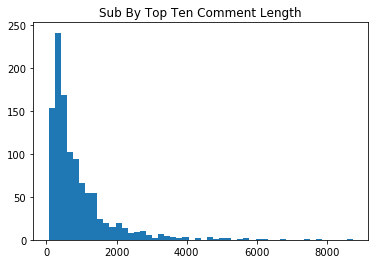

In [226]:
plt.hist(to_model.word_count, bins=50)
plt.title('Sub By Top Ten Comment Length');

In [234]:
to_model = to_model[to_model.word_count >= 500]

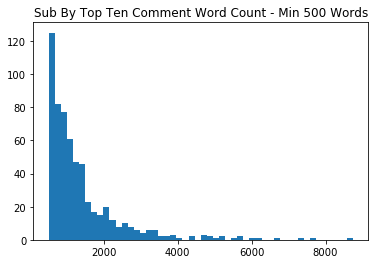

In [237]:
plt.hist(to_model.word_count, bins=50)
plt.title('Sub By Top Ten Comment Word Count - Min 500 Words');

In [236]:
to_model.shape

(600, 3)

# Investigate Frequent Poster Dominating

In [260]:
filtered = sub_with_comms[(sub_with_comms.comm_rank < 11) & (sub_with_comms.num_comments > 10)]
filtered.groupby('author_comm').body.agg('count').sort_values(ascending=False).head(10)

author_comm
dolphins3               820
wildbillcody54          439
VegaThePunisher         378
backpackwayne           362
Gsteel11                348
therecordcorrected      323
Druidshift              252
Maddoktor2              245
kerryfinchelhillary     239
Raspberries-Are-Evil    238
Name: body, dtype: int64

In [262]:
820 / filtered.shape[0]

0.026403065331487265

**TakeAway**

Most frequent poster represents only 3% of total posts after filtering and cleaning. I think I'm ok